In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder # Sudah ada
from sklearn.naive_bayes import GaussianNB # Sudah ada
from mlxtend.feature_selection import SequentialFeatureSelector as SFS # Sudah ada
from sklearn.metrics import confusion_matrix, classification_report # Sudah ada
import matplotlib.pyplot as plt # Sudah ada
import seaborn as sns # Sudah ada
import joblib # Tambahkan ini

LabelEncoder berhasil disimpan ke 'label_encoder_wbc.joblib'
Scaler berhasil disimpan ke 'scaler_wbc.joblib'
Skor akurasi Cross-Validation terbaik dari SFS: 0.9573
Jumlah fitur terpilih: 10
Fitur-fitur terpilih:
['var_nuc_r', 'var_nuc_g', 'mean_sito_g', 'var_sito_g', 'cekung', 'area_nuc', 'entropy_nuc_b', 'ratio_mean_cyto_r_b', 'ratio_mean_cell_r_g', 'ratio_mean_nuc_g_r']
Daftar fitur terpilih berhasil disimpan ke 'selected_features_wbc.joblib'
Model final berhasil disimpan ke 'model_final_wbc.joblib'


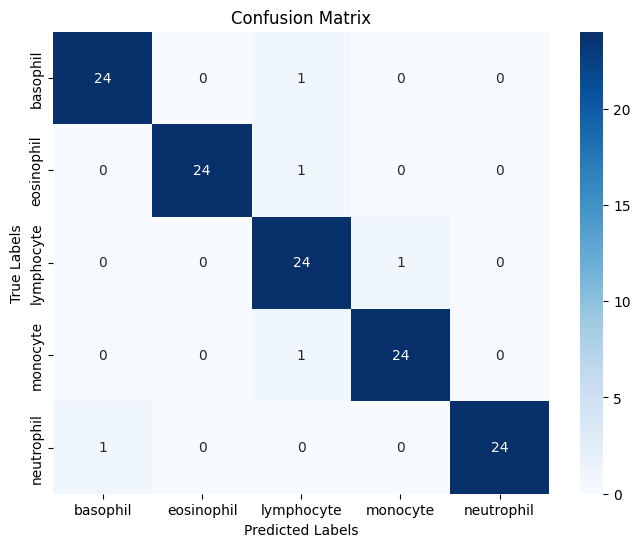

Confusion Matrix:
[[24  0  1  0  0]
 [ 0 24  1  0  0]
 [ 0  0 24  1  0]
 [ 0  0  1 24  0]
 [ 1  0  0  0 24]]
------------------------------
Laporan Klasifikasi:
              precision    recall  f1-score   support

    basophil       0.96      0.96      0.96        25
  eosinophil       1.00      0.96      0.98        25
  lymphocyte       0.89      0.96      0.92        25
    monocyte       0.96      0.96      0.96        25
  neutrophil       1.00      0.96      0.98        25

    accuracy                           0.96       125
   macro avg       0.96      0.96      0.96       125
weighted avg       0.96      0.96      0.96       125



In [3]:
df = pd.read_csv("data_wbc.csv")
df.dropna(subset=df.columns.difference(['nama_file']), inplace=True)
kolom_fitur = [
    'mean_nuc_r', 'var_nuc_r', 'mean_nuc_g', 'var_nuc_g',
    'mean_sito_g', 'var_sito_g', 'cekung', 'ratio_nuc_cell', 'area_nuc',
    'kebulatan', 'entropy_nuc_b', 'entropy_cell_r', 'ratio_mean_cyto_r_b',
    'ratio_mean_cell_r_g', 'ratio_mean_nuc_g_r'
]
kolom_target = 'label'

missing_cols = [col for col in kolom_fitur if col not in df.columns]
if missing_cols:
    print(f"Error: Kolom fitur berikut tidak ditemukan di CSV: {missing_cols}")
    exit()
if kolom_target not in df.columns:
    print(f"Error: Kolom target '{kolom_target}' tidak ditemukan di CSV.")
    exit()

X = df[kolom_fitur]
y_text = df[kolom_target]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_text)
# Menyimpan LabelEncoder
joblib.dump(label_encoder, 'label_encoder_wbc.joblib')
print("LabelEncoder berhasil disimpan ke 'label_encoder_wbc.joblib'")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # X_test_scaled akan digunakan nanti untuk evaluasi, tidak perlu disimpan jika scaler-nya yang disimpan
# Menyimpan Scaler
joblib.dump(scaler, 'scaler_wbc.joblib')
print("Scaler berhasil disimpan ke 'scaler_wbc.joblib'")

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=kolom_fitur)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=kolom_fitur) # Tetap dibutuhkan untuk evaluasi dalam skrip ini
model_nb = GaussianNB()

min_samples_per_class_train = pd.Series(y_train).value_counts().min() if len(pd.Series(y_train).value_counts()) > 0 else 2
jumlah_lipatan_cv = min(5, min_samples_per_class_train)
if jumlah_lipatan_cv < 2:
    jumlah_lipatan_cv = 2
    print(f"Peringatan: Jumlah sampel kelas minoritas pada data latih sangat kecil. CV diatur ke {jumlah_lipatan_cv}.")

sfs = SFS(estimator=model_nb,
          k_features=(1, len(kolom_fitur)),
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=jumlah_lipatan_cv,
          n_jobs=-1)
sfs.fit(X_train_scaled_df, y_train)

print(f'Skor akurasi Cross-Validation terbaik dari SFS: {sfs.k_score_:.4f}')
print(f'Jumlah fitur terpilih: {len(sfs.k_feature_names_)}')
selected_features_list = list(sfs.k_feature_names_) # Ambil list nama fitur
print('Fitur-fitur terpilih:')
print(selected_features_list)
# Menyimpan daftar nama fitur terpilih
joblib.dump(selected_features_list, 'selected_features_wbc.joblib')
print("Daftar fitur terpilih berhasil disimpan ke 'selected_features_wbc.joblib'")

X_train_sfs = X_train_scaled_df[selected_features_list]
X_test_sfs = X_test_scaled_df[selected_features_list] # Ini menggunakan X_test_scaled_df yang dibuat sebelumnya
model_final_nb = GaussianNB()
model_final_nb.fit(X_train_sfs, y_train)
# Menyimpan model final yang sudah dilatih
joblib.dump(model_final_nb, 'model_final_wbc.joblib')
print("Model final berhasil disimpan ke 'model_final_wbc.joblib'")

# Bagian evaluasi dan visualisasi tetap sama
y_pred_test = model_final_nb.predict(X_test_sfs)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:")
print(cm)
print("-" * 30)

report = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_, zero_division=0)
print("Laporan Klasifikasi:")
print(report)

In [10]:
import pandas as pd



label_encoder = joblib.load('label_encoder_wbc.joblib')
scaler = joblib.load('scaler_wbc.joblib')
selected_features_list = joblib.load('selected_features_wbc.joblib')
model_final_nb = joblib.load('model_final_wbc.joblib')
print("Model dan objek pendukung berhasil dimuat.")




kolom_fitur_awal = [
    'mean_nuc_r', 'var_nuc_r', 'mean_nuc_g', 'var_nuc_g',
    'mean_sito_g', 'var_sito_g', 'cekung', 'ratio_nuc_cell', 'area_nuc',
    'kebulatan', 'entropy_nuc_b', 'entropy_cell_r', 'ratio_mean_cyto_r_b',
    'ratio_mean_cell_r_g', 'ratio_mean_nuc_g_r'
]



df = pd.read_csv("data_wbc.csv")
data_baru_df = pd.DataFrame([df.loc[102, kolom_fitur_awal].tolist()], columns=kolom_fitur_awal)




data_baru_scaled = scaler.transform(data_baru_df)
data_baru_scaled_df = pd.DataFrame(data_baru_scaled, columns=kolom_fitur_awal)
data_baru_final_features = data_baru_scaled_df[selected_features_list]

prediksi_numerik = model_final_nb.predict(data_baru_final_features)
prediksi_teks = label_encoder.inverse_transform(prediksi_numerik)
print(f"Hasil prediksi {prediksi_teks[0]}")



print("\n--- Prediksi Selesai ---")

Model dan objek pendukung berhasil dimuat.
Hasil prediksi lymphocyte

--- Prediksi Selesai ---
